# Appendix F

### Apendix F.1 Importing Libraries

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time

Using TensorFlow backend.


### F.2 Loading Dataset

In [2]:
#reading in datasets and selecting subset of columns that will be used for modelling

train = pd.read_csv('train_ts.csv').drop(['Unnamed: 0'],axis = 1)
test = pd.read_csv('test_ts.csv').drop(['Unnamed: 0'],axis = 1)
validation = pd.read_csv('validation_ts.csv').drop(['Unnamed: 0'],axis = 1)
train_subset = train[['date','Total','WindSpeed','Precip','Temperature','holidays','closed','closedxholidays']]
test_subset = test[['date','Total','WindSpeed','Precip','Temperature','holidays','closed','closedxholidays']]
validation_subset = validation[['date','Total','WindSpeed','Precip','Temperature','holidays','closed','closedxholidays']]

In [3]:
train_subset.head()

,date,Total,WindSpeed,Precip,Temperature,holidays,closed,closedxholidays
0,2019-09-29 12:00:00,76.0,13.0,0.0,14.0,0,0,0
1,2019-09-29 13:00:00,78.0,15.0,0.0,15.0,0,0,0
2,2019-09-29 14:00:00,66.0,18.0,0.0,15.0,0,0,0
3,2019-09-29 15:00:00,67.0,16.0,0.0,16.0,0,0,0
4,2019-09-29 16:00:00,84.0,16.0,0.0,16.0,0,0,0


In [4]:
#setting index as date for each dataset and then obtaining their values as a numpy array 
test_values = test_subset.copy().set_index('date')
test_values = test_values.values
train_values = train_subset.copy().set_index('date')
train_values = train_values.values
validation_values = validation_subset.copy().set_index('date')
validation_values = validation_values.values

### F.2 Declaring Data Prepration Functions

In [5]:
#Extracted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
#Few tweaks to make it work for my data 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [33]:
#Input steps specifying the amount of lag variables to be outputed
#train_values corresponding set of values
#validation_values corresponding set of values
#test_values  corresponding set of values
#outputs dataframe with corresponding lag variables
def timestep_maker(steps,train_values,validation_values,test_values):
    #Using min max scaler to scale data between 0 and 1 as RNNs use a hyperbolic tangent activation function which outputs values between 0 and 1 
    scaler  = MinMaxScaler()
    scaled  = scaler.fit_transform(train_values)
    scaled_validation = scaler.fit_transform(validation_values)
    scaled_test  = scaler.fit_transform(test_values)

    #Using series to supervised function to make the datasets 
    vals = series_to_supervised(scaled, steps, 1)
    vals_test  = series_to_supervised(scaled_test, steps, 1)
    vals_val  = series_to_supervised(scaled_validation, steps, 1)
    #Returns training test and validation sets 
    return vals, vals_test, vals_val,scaler


In [7]:
#Set maker function 
#Correctly formats each data set into correct shape to input into nueral network
#inputs
#step dataframe with timestep_maker format training set values
#step dataframe with timestep_maker format test test set values
#step_val dataframe with timestep_maker format validation set values
#columns intiger number of columns
#steps intiger number of steps to take

def set_maker(step,step_test,step_val,columns,steps): 
    #Gets var1 which is the target value
    test_y  = step_test[['var1(t)']].values
    train_y  = step[['var1(t)']].values
    val_y  = step_val[['var1(t)']].values
    
    #drops val1 and reshapes the dataframes for input into a numpy tensor 
    test_X  = step_test.iloc[:,:columns * steps + 1]
    test_X  = test_X.copy().drop(['var1(t)'],axis =1 ).values
    test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    val_X  = step_val.iloc[:,:columns * steps + 1]
    val_X  = val_X.copy().drop(['var1(t)'],axis =1 ).values
    val_X  = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    
    train_X  = step.iloc[:,:columns * steps + 1]
    train_X  = train_X.copy().drop(['var1(t)'],axis =1 ).values
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    return train_X,test_X,train_y,test_y,val_y,val_X

### F.2 Declaring Modelling Functions

In [8]:
#functions single
#single layer neural network uses an LSTM or long short term emmory cell as the recurrent part initially takes 50 nuerons
#Dense layer for a single output 
#Ueses adam optimizer and mean absolute error as loss function 
#inputs 
#train_x predictor values for training set
#test_X predictor values for test set
#train_y response values for training set
#test_y response values for test set
#val_y response values for validation set
#val_x predictor values for validation set
#batch number of training batches 
def grid_search(iterations,train_values,test_values,validation_values,model_maker,cols = 7, batch = 32 ):
    
    error_list = []
    for i in tqdm(range(1,iterations) ):
        step, step_test, step_val,scaler = timestep_maker(i,train_values,test_values,validation_values)
  
        train_X,test_X,train_y,test_y,val_y,val_X = set_maker(step,step_test,step_val,cols,i)
    
        fit = model_maker(train_X,test_X,train_y,test_y,val_y,val_X , batch)
        rmse = evaluation(fit,val_X,val_y,scaler )
        error_list.append(rmse)
        
    return error_list

In [32]:
#Helper function 
#Extracted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def evaluation(net,test_X,test_y,scaler):
    # make a prediction
    yhat = net.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast

    # invert scaling for actual
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse

In [34]:
#model_spitter 
#grid searches for best amount of steps with input model outputs list rmse of each model in the grid
#inputs 
#train_values corresponding dataset
#test_values corresponding dataset
#validation values corresponding dataset
#model_maker specifies the type of model to use
#cols number of columns by default 7
#outputs trained model with specific iterations
#outputs model predictions and real values

def model_spitter(train_values,test_values,validation_values,model_maker,steps = 2, cols = 7 ):
    
   
    step, step_test, step_val,scaler = timestep_maker(steps,train_values,test_values,validation_values)

    train_X,test_X,train_y,test_y,val_y,val_X = set_maker(step,step_test,step_val,cols,steps)

    fit = model_maker(train_X,test_X,train_y,test_y,val_y,val_X , 74)
    
    yhat = fit.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast

    # invert scaling for actual
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
        
    return fit,inv_yhat,inv_y

In [10]:
#functions single
#single layer neural network uses an LSTM or long short term emmory cell as the recurrent part initially takes 50 nuerons
#Dense layer for a single output 
#Ueses adam optimizer and mean absolute error as loss function 
#inputs 
#train_x predictor values for training set
#test_X predictor values for test set
#train_y response values for training set
#test_y response values for test set
#val_y response values for validation set
#val_x predictor values for validation set
#batch number of training batches 
def single(train_X,test_X,train_y,test_y,val_y,val_X , batch = 32):
    single_layer = Sequential()
    single_layer.add(LSTM(50,input_shape = (train_X.shape[1],train_X.shape[2])))
    single_layer.add(Dense(1))
    single_layer.compile(loss = 'mae',optimizer  = 'adam')
    hist = single_layer.fit(train_X,train_y,epochs = 50, batch_size =batch, verbose =0,shuffle = False,validation_data=(val_X, val_y))


    
    return single_layer


In [12]:
#functions dropout_layer
#single layer neural network uses an LSTM or long short term emmory cell as the recurrent part initially takes 50 nuerons 
#Dense layer for a single output 
#introduces a dropout layer for regularization
#Ueses adam optimizer and mean absolute error as loss function 
#inputs 
#train_x predictor values for training set
#test_X predictor values for test set
#train_y response values for training set
#test_y response values for test set
#val_y response values for validation set
#val_x predictor values for validation set
#batch number of training batches 
def dropout_layer(train_X,test_X,train_y,test_y,val_y,val_X,batch):
    model = Sequential()
    model.add(LSTM(50,input_shape = (train_X.shape[1],train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mae',optimizer  = 'adam')
    hist = model.fit(train_X,train_y,epochs = 50, batch_size = 74, verbose =0,shuffle = False,validation_data=(val_X, val_y))


    
    return model

In [13]:
#functions multi_layer
#single layer neural network uses an LSTM or long short term emmory cell as the recurrent part initially takes 50 nuerons
#Adds a second LSTM layer with 100 input cells 
#both LSTM cells have dropout layers for regularization
#Ueses adam optimizer and mean absolute error as loss function 
#inputs 
#train_x predictor values for training set
#test_X predictor values for test set
#train_y response values for training set
#test_y response values for test set
#val_y response values for validation set
#val_x predictor values for validation set
#batch number of training batches 
def multi_layer(train_X,test_X,train_y,test_y,val_y,val_X,batch):
    model = Sequential()
    model.add(LSTM(50,input_shape = (train_X.shape[1],train_X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(100,input_shape = (train_X.shape[1],train_X.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.compile(loss = 'mae',optimizer  = 'adam')
    hist = model.fit(train_X,train_y,epochs = 50, batch_size =32, verbose =0,shuffle = False,validation_data=(val_X, val_y))


    
    return model

### F.4 Training Models

In [ ]:
#Models will be saved into csv files due to how time consuming grid search is
grid = grid_search(24,train_values,test_values,validation_values,single)
np.savetxt('grid.csv', grid, delimiter=',', fmt='%d')

In [ ]:
grid_batch = grid_search(24,train_values,test_values,validation_values,single, 74 )
np.savetxt('grid_batch.csv', grid_batch, delimiter=',', fmt='%d')

In [ ]:
grid_batch_bigger = grid_search(11,train_values,test_values,validation_values,dropout_layer, 148 )
np.savetxt('grid_batch_bigger.csv', grid_batch_bigger, delimiter=',', fmt='%d')

In [ ]:
grid_dropout = grid_search(24,train_values,test_values,validation_values,dropout_layer)
np.savetxt('grid_dropout.csv', grid_dropout, delimiter=',', fmt='%d')

In [ ]:
grid_dropout_batch = grid_search(24,train_values,test_values,validation_values,dropout_layer,74)
np.savetxt('grid_dropout_batch.csv', grid_dropout_batch, delimiter=',', fmt='%d')

In [ ]:
grid_multilayer = grid_search(12,train_values,test_values,validation_values,multi_layer,74)
np.savetxt('grid_multilayer.csv', grid_dropout_batch, delimiter=',', fmt='%d')

### F.5 Model Evaluation

In [14]:
grid = np.loadtxt('grid.csv')

28.0


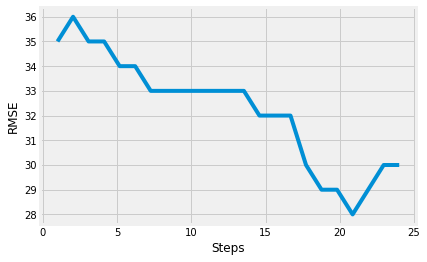

In [15]:
x_range = np.linspace(1,24,23)
plt.plot(x_range,grid)
plt.xlabel('Steps')
plt.ylabel('RMSE')
print(np.min(grid))

In [16]:
grid_batch = np.loadtxt('grid_batch.csv')

17.0


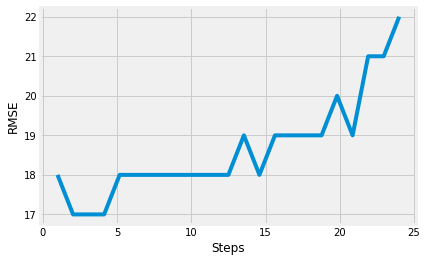

In [17]:
x_range = np.linspace(1,24,23)
plt.plot(x_range,grid_batch)
plt.xlabel('Steps')
plt.ylabel('RMSE')
print(np.min(grid_batch))

In [18]:
grid_dropout = np.loadtxt('grid_dropout.csv')

Text(0, 0.5, 'RMSE')

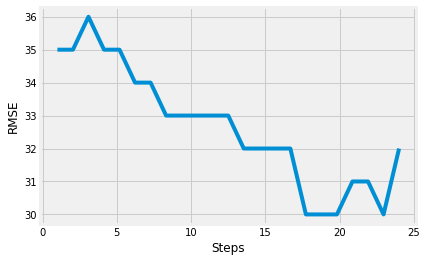

In [19]:
x_range = np.linspace(1,24,23)
plt.plot(x_range,grid_dropout)
plt.xlabel('Steps')
plt.ylabel('RMSE')


In [20]:
grid_dropout_batch = np.loadtxt('grid_dropout_batch.csv')

Text(0, 0.5, 'RMSE')

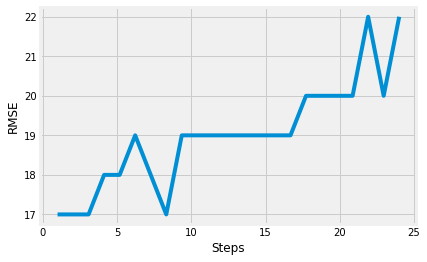

In [21]:
x_range = np.linspace(1,24,23)
plt.plot(x_range,grid_dropout_batch)
plt.xlabel('Steps')
plt.ylabel('RMSE')


In [22]:
grid_multilayer = np.loadtxt('grid_multilayer.csv')

Text(0, 0.5, 'RMSE')

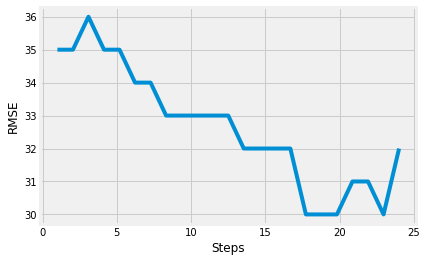

In [23]:
x_range = np.linspace(1,24,23)
plt.plot(x_range,grid_dropout)
plt.xlabel('Steps')
plt.ylabel('RMSE')


In [24]:
grid_batch_bigger = np.loadtxt('grid_batch_bigger.csv')

Text(0, 0.5, 'RMSE')

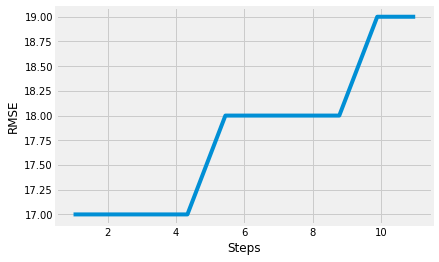

In [25]:

x_range = np.linspace(1,11,10)
plt.plot(x_range,grid_batch_bigger)
plt.xlabel('Steps')
plt.ylabel('RMSE')

### F.6 Test Set Evaluation

In [38]:
rmse_arr = np.zeros(50)
for i in range(50):
    final_fit,inv_yhat,inv_y  = model_spitter(train_values,test_values,validation_values,dropout_layer,cols = 7 )
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_arr[i] = rmse

In [39]:
import seaborn as sns

Text(0.5, 0, 'RMSE')

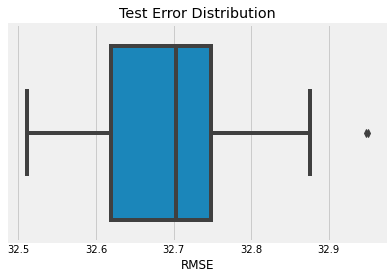

In [44]:
ax = sns.boxplot(rmse_arr)
ax.set_title('Test Error Distribution')
ax.set_xlabel('RMSE')

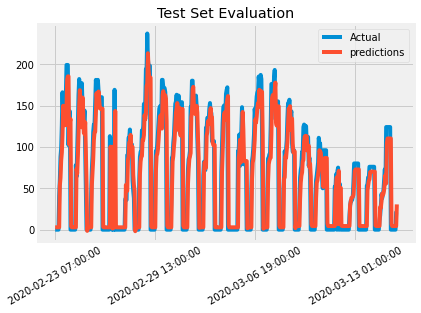

In [46]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots()



loc = plticker.MultipleLocator(base=150) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(test.date[-len(inv_y):],inv_y,label = 'Actual')
ax.plot(test.date[-len(inv_y):],inv_yhat,label = 'predictions')
ax.set_title("Test Set Evaluation")
plt.xticks(rotation=30)
plt.legend()